In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import numpy.random as nr
import sklearn.model_selection as ms
from sklearn import preprocessing

In [2]:
df = pd.read_csv('ncaa_matches_binned.csv')
Labels = df['Win']
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(['Win'], axis=1, inplace=True)
Features = np.array(df)
print(Features.shape)
df.head()

(87504, 30)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1421.0,1411.0,2,2,2,0,1,2,1,1,...,0,3,3,3,3,1,0,2,2,1
1,1436.0,1112.0,1,1,1,0,0,2,2,1,...,0,3,3,3,3,3,3,1,3,0
2,1272.0,1113.0,3,3,3,1,1,3,3,3,...,2,2,2,0,2,3,2,1,2,1
3,1166.0,1141.0,3,3,2,3,2,2,0,0,...,2,2,1,2,0,0,0,2,0,3
4,1143.0,1301.0,2,2,2,0,0,2,1,1,...,1,2,2,2,3,3,3,1,3,0


In [2]:
def split_and_rescale_data(Features, Labels):
    # Randomly sample cases to create independent training and test data
    nr.seed(1115)
    indx = range(Features.shape[0])
    indx = ms.train_test_split(indx, test_size = int(Features.shape[0]*0.25))
    X_train = Features[indx[0],:]
    y_train = np.ravel(Labels[indx[0]])
    X_test = Features[indx[1],:]
    y_test = np.ravel(Labels[indx[1]])
    
    # Rescale numeric features
    scaler = preprocessing.MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    print(X_train.shape)
    #X_train[:5,:]
    return X_train, y_train, X_test, y_test

# Model1 All Features Binned

In [4]:
# I tried a alot of different neural network structures this one is one of the best. 
# More complext networks are all slightly worse than this one.

In [5]:
X_train, y_train, X_test, y_test = split_and_rescale_data(Features, Labels)

(65628, 30)


In [6]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(256, activation=activation_fn)(inputs)
x = tf.keras.layers.Dense(256, activation=activation_fn)(x)
x = tf.keras.layers.Dense(128, activation=activation_fn)(x)
x = tf.keras.layers.Dense(64, activation=activation_fn)(x)
x = tf.keras.layers.Dense(32, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])


In [7]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 6s 106us/sample - loss: 0.6364 - accuracy: 0.6295 - AUC: 0.6852 - Precision: 0.6275 - Recall: 0.6304 - val_loss: 0.6266 - val_accuracy: 0.6462 - val_AUC: 0.7028 - val_Precision: 0.6571 - val_Recall: 0.6208
Epoch 2/100
52502/52502 [==============================] - 4s 77us/sample - loss: 0.6296 - accuracy: 0.6387 - AUC: 0.6957 - Precision: 0.6322 - Recall: 0.6564 - val_loss: 0.6239 - val_accuracy: 0.6423 - val_AUC: 0.7019 - val_Precision: 0.6519 - val_Recall: 0.6202
Epoch 3/100
52502/52502 [==============================] - 4s 75us/sample - loss: 0.6270 - accuracy: 0.6383 - AUC: 0.6978 - Precision: 0.6312 - Recall: 0.6589 - val_loss: 0.6246 - val_accuracy: 0.6501 - val_AUC: 0.7061 - val_Precision: 0.6466 - val_Recall: 0.6717
Epoch 4/100
52502/52502 [==============================] - 4s 76us/sample - loss: 0.6239 - accuracy: 0.6423 - AUC: 0.7022 - Precision: 0.6379 - Recall: 0.652

In [8]:
# Prediction on training
model.evaluate(X_train, y_train, verbose=2)

65628/1 - 2s - loss: 0.6140 - accuracy: 0.6575 - AUC: 0.7231 - Precision: 0.6485 - Recall: 0.6853


[0.6075262983451125, 0.6575395, 0.72307724, 0.64849484, 0.68529993]

In [9]:
# Prediction on training
model.evaluate(X_test,  y_test, verbose=2)

21876/1 - 1s - loss: 0.5946 - accuracy: 0.6470 - AUC: 0.7092 - Precision: 0.6411 - Recall: 0.6697


[0.6188119750045558, 0.64701045, 0.7092022, 0.64105254, 0.6697415]

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0     

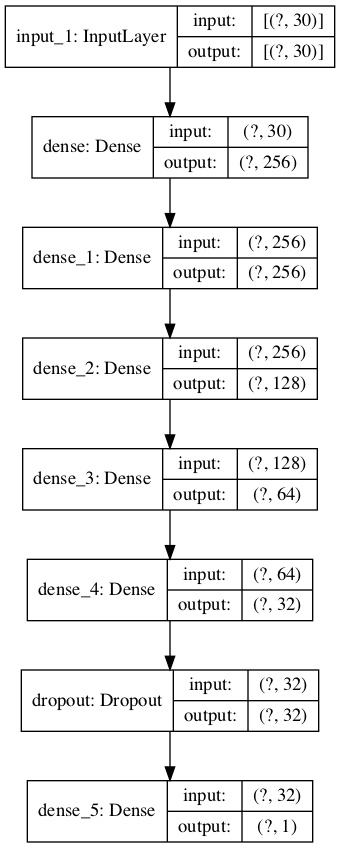

In [11]:
tf.keras.utils.plot_model(model, 'neural_network_shape_info.png', show_shapes=True)

# Model2 Only Team Scores Binned

In [12]:
Features2 = np.array(df[['Team1', 'Team2', 'Team1Score', 'Team2Score']])#, 'Team1FGM', 'Team1FGA', 'Team2FGM', 'Team2FGA']])
X_train2, y_train2, X_test2, y_test2 = split_and_rescale_data(Features2, Labels)

(65628, 4)


In [13]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train2.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(32, activation=activation_fn)(inputs)
x = tf.keras.layers.Dense(8, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [14]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model2.fit(X_train2, y_train2, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 4s 69us/sample - loss: 0.6696 - accuracy: 0.5864 - AUC: 0.6232 - Precision: 0.5856 - Recall: 0.5802 - val_loss: 0.6614 - val_accuracy: 0.5954 - val_AUC: 0.6460 - val_Precision: 0.6109 - val_Recall: 0.5392
Epoch 2/100
52502/52502 [==============================] - 3s 48us/sample - loss: 0.6662 - accuracy: 0.5895 - AUC: 0.6307 - Precision: 0.5836 - Recall: 0.6136 - val_loss: 0.6592 - val_accuracy: 0.5987 - val_AUC: 0.6469 - val_Precision: 0.6089 - val_Recall: 0.5657
Epoch 3/100
52502/52502 [==============================] - 3s 48us/sample - loss: 0.6654 - accuracy: 0.5931 - AUC: 0.6326 - Precision: 0.5882 - Recall: 0.6106 - val_loss: 0.6593 - val_accuracy: 0.6020 - val_AUC: 0.6471 - val_Precision: 0.5888 - val_Recall: 0.6925
Epoch 4/100
52502/52502 [==============================] - 2s 47us/sample - loss: 0.6649 - accuracy: 0.5926 - AUC: 0.6326 - Precision: 0.5869 - Recall: 0.6148

In [15]:
# Prediction on training
model2.evaluate(X_train2, y_train2, verbose=2)

65628/1 - 2s - loss: 0.6511 - accuracy: 0.5959 - AUC: 0.6400 - Precision: 0.6026 - Recall: 0.5591


[0.6613427002134827, 0.5959499, 0.6399871, 0.60263246, 0.5591208]

In [16]:
# Prediction on training
model2.evaluate(X_test2,  y_test2, verbose=2)

21876/1 - 1s - loss: 0.6550 - accuracy: 0.5920 - AUC: 0.6373 - Precision: 0.5995 - Recall: 0.5569


[0.6620842393431156, 0.59201866, 0.6373043, 0.5994888, 0.55694586]

In [17]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


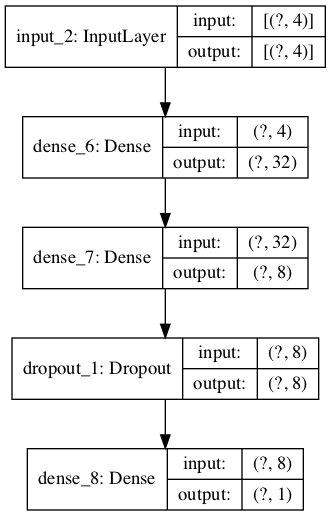

In [18]:
tf.keras.utils.plot_model(model2, 'neural_network_shape_info2.png', show_shapes=True)

# Model3 Features Binned Selected by PCA

In [19]:
Features3 = np.array(df[['Team1', 'Team2', 'Team1Score', 'Team1FGM', 'Team1FGA', 'Team1FGM3', 'Team1FGA3', 'Team1FTM', 'Team1FTA', 'Team1OR', 'Team1DR', 'Team1Ast', 
                        'Team2Score', 'Team2FGM', 'Team2FGA', 'Team2FGM3', 'Team2FGA3', 'Team2FTM', 'Team2FTA', 'Team2OR', 'Team2DR', 'Team2Ast']])
X_train3, y_train3, X_test3, y_test3 = split_and_rescale_data(Features3, Labels)

(65628, 22)


In [20]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train3.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(256, activation=activation_fn)(inputs)
x = tf.keras.layers.Dense(256, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [21]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model3.fit(X_train3, y_train3, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 5s 89us/sample - loss: 0.6498 - accuracy: 0.6133 - AUC: 0.6619 - Precision: 0.6125 - Recall: 0.6088 - val_loss: 0.6404 - val_accuracy: 0.6259 - val_AUC: 0.6783 - val_Precision: 0.6236 - val_Recall: 0.6466
Epoch 2/100
52502/52502 [==============================] - 3s 66us/sample - loss: 0.6451 - accuracy: 0.6190 - AUC: 0.6697 - Precision: 0.6160 - Recall: 0.6241 - val_loss: 0.6389 - val_accuracy: 0.6312 - val_AUC: 0.6816 - val_Precision: 0.6253 - val_Recall: 0.6660
Epoch 3/100
52502/52502 [==============================] - 3s 67us/sample - loss: 0.6429 - accuracy: 0.6203 - AUC: 0.6723 - Precision: 0.6203 - Recall: 0.6129 - val_loss: 0.6407 - val_accuracy: 0.6310 - val_AUC: 0.6830 - val_Precision: 0.6403 - val_Recall: 0.6083
Epoch 4/100
52502/52502 [==============================] - 4s 68us/sample - loss: 0.6399 - accuracy: 0.6252 - AUC: 0.6767 - Precision: 0.6260 - Recall: 0.6147

In [22]:
# Prediction on training
model3.evaluate(X_train3, y_train3, verbose=2)

65628/1 - 2s - loss: 0.6319 - accuracy: 0.6348 - AUC: 0.6947 - Precision: 0.6593 - Recall: 0.5552


[0.630912161126988, 0.63479, 0.69465405, 0.65928286, 0.5551824]

In [23]:
# Prediction on test
model3.evaluate(X_test3,  y_test3, verbose=2)

21876/1 - 1s - loss: 0.6201 - accuracy: 0.6226 - AUC: 0.6825 - Precision: 0.6461 - Recall: 0.5438


[0.6387078868752097, 0.62260014, 0.6824659, 0.6461204, 0.543794]

In [24]:
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               5888      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 71,937
Trainable params: 71,937
Non-trainable params: 0
_________________________________________________________________


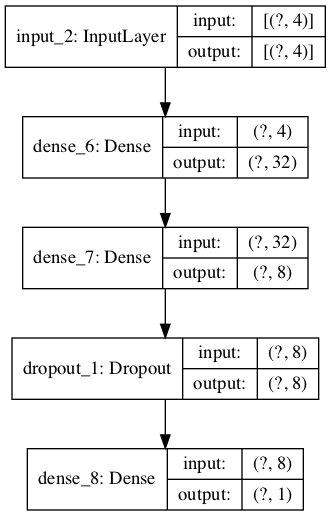

In [25]:
tf.keras.utils.plot_model(model2, 'neural_network_shape_info3.png', show_shapes=True)

# Model4: Delta and Team Features - NOT Binned

In [26]:
df2 = pd.read_csv('delta_matches.csv')
Labels = df2['Win']
df2.drop(df2.columns[0], axis=1, inplace=True)
df2.drop(['Win'], axis=1, inplace=True)
Features2 = np.array(df2)
print(Features2.shape)
df2.head()

(87504, 44)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,1421.0,1411.0,70.857116,24.835506,56.434951,6.414692,18.565785,14.771413,20.665618,10.963364,...,0.881936,-0.939267,-3.340163,-0.742632,-0.677068,1.729802,-0.756330,0.648304,0.664272,-0.607997
1,1436.0,1112.0,69.855278,24.480532,53.811272,5.963383,16.755914,14.930832,21.279172,10.879975,...,-0.800801,-1.394677,-0.973109,-0.543107,-0.034545,-1.456050,0.284372,-0.239265,0.017690,0.474607
2,1272.0,1113.0,74.907473,26.294729,58.543421,6.600664,19.351685,15.717352,23.277168,12.826705,...,-0.985461,0.735616,1.798324,2.440904,1.049760,0.727133,0.345803,1.952151,1.948516,0.417965
3,1166.0,1141.0,73.853850,25.786073,55.304019,8.163962,21.624711,14.117741,19.608092,9.641230,...,-0.370801,-0.531874,-1.177037,-1.441776,2.729467,3.557566,-1.665977,-0.634785,0.228078,-2.998282
4,1143.0,1301.0,70.866565,25.397341,56.385076,5.714419,16.266095,14.357464,20.499749,10.694625,...,-2.476242,-0.625295,-0.568383,-0.464428,0.210106,-0.569521,-0.228914,-0.782866,-0.714186,0.253653


In [27]:
X_train4, y_train4, X_test4, y_test4 = split_and_rescale_data(Features2, Labels)

(65628, 44)


In [28]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train4.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(2048, activation=activation_fn)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [29]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model4.fit(X_train4, y_train4, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 42s 809us/sample - loss: 0.6888 - accuracy: 0.6235 - AUC: 0.6696 - Precision: 0.6238 - Recall: 0.6152 - val_loss: 0.6294 - val_accuracy: 0.6291 - val_AUC: 0.6974 - val_Precision: 0.6645 - val_Recall: 0.5310
Epoch 2/100
52502/52502 [==============================] - 39s 736us/sample - loss: 0.6296 - accuracy: 0.6430 - AUC: 0.7010 - Precision: 0.6408 - Recall: 0.6446 - val_loss: 0.6393 - val_accuracy: 0.6127 - val_AUC: 0.7112 - val_Precision: 0.7643 - val_Recall: 0.3328
Epoch 3/100
52502/52502 [==============================] - 39s 737us/sample - loss: 0.6250 - accuracy: 0.6477 - AUC: 0.7068 - Precision: 0.6436 - Recall: 0.6558 - val_loss: 0.6100 - val_accuracy: 0.6554 - val_AUC: 0.7196 - val_Precision: 0.6564 - val_Recall: 0.6613
Epoch 4/100
52502/52502 [==============================] - 39s 736us/sample - loss: 0.6227 - accuracy: 0.6498 - AUC: 0.7093 - Precision: 0.6488 - Recall

In [30]:
# Prediction on training
model4.evaluate(X_train4, y_train4, verbose=2)

65628/1 - 10s - loss: 0.5971 - accuracy: 0.6545 - AUC: 0.7198 - Precision: 0.6656 - Recall: 0.6188


[0.6114723057003455, 0.6545377, 0.7198282, 0.6655502, 0.6187758]

In [31]:
# Prediction on test
model4.evaluate(X_test4,  y_test4, verbose=2)

21876/1 - 3s - loss: 0.6060 - accuracy: 0.6521 - AUC: 0.7176 - Precision: 0.6650 - Recall: 0.6143


[0.6129494197605341, 0.65208447, 0.7176101, 0.6650188, 0.6143027]

In [32]:
model4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              92160     
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096

# Model5: All Features and NOT Binned

In [33]:
df3 = pd.read_csv('matches.csv').dropna()
Labels = df3['Win']
#df3.drop(df3.columns[0], axis=1, inplace=True)
df3.drop(['Win'], axis=1, inplace=True)
Features3 = np.array(df3)
print(Features3.shape)
df3.head()

(87504, 30)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1421.0,1411.0,70.857116,24.835506,56.434951,6.414692,18.565785,14.771413,20.665618,10.963364,...,17.683849,15.710680,24.005781,11.705997,24.357526,12.123150,15.493189,6.690597,3.153172,18.467932
1,1436.0,1112.0,69.855278,24.480532,53.811272,5.963383,16.755914,14.930832,21.279172,10.879975,...,17.556715,16.325509,22.252281,11.423081,25.023546,14.801796,12.812651,6.345888,3.615896,16.994665
2,1272.0,1113.0,74.907473,26.294729,58.543421,6.600664,19.351685,15.717352,23.277168,12.826705,...,20.337147,14.981736,21.478844,10.385801,23.829096,14.160912,13.034717,6.020814,3.427225,18.325749
3,1166.0,1141.0,73.853850,25.786073,55.304019,8.163962,21.624711,14.117741,19.608092,9.641230,...,21.995512,14.649615,20.785129,11.083005,21.987842,11.666412,14.050869,6.743972,2.753055,20.340310
4,1143.0,1301.0,70.866565,25.397341,56.385076,5.714419,16.266095,14.357464,20.499749,10.694625,...,18.742337,14.982759,21.068132,11.159053,24.149595,14.311193,12.886297,6.121473,4.054906,17.563236


In [34]:
X_train5, y_train5, X_test5, y_test5 = split_and_rescale_data(Features3, Labels)

(65628, 30)


In [64]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train5.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(2048, activation=activation_fn)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model5.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [65]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model5.fit(X_train5, y_train5, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 47s 902us/sample - loss: 0.6891 - accuracy: 0.6185 - AUC: 0.6636 - Precision: 0.6170 - Recall: 0.6172 - val_loss: 0.6459 - val_accuracy: 0.6103 - val_AUC: 0.6864 - val_Precision: 0.5760 - val_Recall: 0.8542
Epoch 2/100
52502/52502 [==============================] - 47s 900us/sample - loss: 0.6306 - accuracy: 0.6431 - AUC: 0.7003 - Precision: 0.6434 - Recall: 0.6361 - val_loss: 0.6203 - val_accuracy: 0.6496 - val_AUC: 0.7160 - val_Precision: 0.6865 - val_Recall: 0.5586
Epoch 3/100
52502/52502 [==============================] - 46s 871us/sample - loss: 0.6260 - accuracy: 0.6486 - AUC: 0.7053 - Precision: 0.6432 - Recall: 0.6617 - val_loss: 0.6273 - val_accuracy: 0.6347 - val_AUC: 0.7179 - val_Precision: 0.5983 - val_Recall: 0.8337
Epoch 4/100
52502/52502 [==============================] - 46s 871us/sample - loss: 0.6235 - accuracy: 0.6497 - AUC: 0.7086 - Precision: 0.6460 - Recall

In [66]:
# Prediction on training
model5.evaluate(X_train5, y_train5, verbose=2)

65628/1 - 11s - loss: 0.6144 - accuracy: 0.6523 - AUC: 0.7216 - Precision: 0.6788 - Recall: 0.5758


[0.6209212286443112, 0.65228254, 0.7216066, 0.67877066, 0.5758205]

In [67]:
# Prediction on test
model5.evaluate(X_test5,  y_test5, verbose=2)

21876/1 - 4s - loss: 0.6292 - accuracy: 0.6532 - AUC: 0.7217 - Precision: 0.6819 - Recall: 0.5758


[0.6214546585109164, 0.65322727, 0.7217171, 0.6818821, 0.57576036]

In [68]:
model5.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_46 (Dense)             (None, 2048)              63488     
_________________________________________________________________
batch_normalization_20 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_21 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_48 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_22 (Batc (None, 1024)              4096

# Modeel6: Team ID and Scores Unbinned

In [40]:
Features4 = np.array(df3[['Team1', 'Team2', 'Team1Score', 'Team2Score']])#, 'Team1FGM', 'Team1FGA', 'Team2FGM', 'Team2FGA']])
X_train6, y_train6, X_test6, y_test6 = split_and_rescale_data(Features4, Labels)

(65628, 4)


In [41]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train6.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(1024, activation=activation_fn)(inputs)
x = tf.keras.layers.Dense(512, activation=activation_fn)(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [42]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model6.fit(X_train6, y_train6, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 13s 255us/sample - loss: 0.6632 - accuracy: 0.5967 - AUC: 0.6370 - Precision: 0.5932 - Recall: 0.6055 - val_loss: 0.6514 - val_accuracy: 0.6117 - val_AUC: 0.6607 - val_Precision: 0.6156 - val_Recall: 0.6075
Epoch 2/100
52502/52502 [==============================] - 12s 235us/sample - loss: 0.6602 - accuracy: 0.6015 - AUC: 0.6434 - Precision: 0.6044 - Recall: 0.5789 - val_loss: 0.6537 - val_accuracy: 0.6103 - val_AUC: 0.6596 - val_Precision: 0.6175 - val_Recall: 0.5925
Epoch 3/100
52502/52502 [==============================] - 12s 236us/sample - loss: 0.6594 - accuracy: 0.6014 - AUC: 0.6445 - Precision: 0.6010 - Recall: 0.5940 - val_loss: 0.6577 - val_accuracy: 0.6137 - val_AUC: 0.6596 - val_Precision: 0.6125 - val_Recall: 0.6320
Epoch 4/100
52502/52502 [==============================] - 12s 236us/sample - loss: 0.6589 - accuracy: 0.6026 - AUC: 0.6450 - Precision: 0.6048 - Recall

In [43]:
# Prediction on training
model6.evaluate(X_train6, y_train6, verbose=2)

65628/1 - 6s - loss: 0.6584 - accuracy: 0.6015 - AUC: 0.6512 - Precision: 0.6316 - Recall: 0.4837


[0.6572127004765996, 0.60149634, 0.6511786, 0.6315873, 0.4837124]

In [44]:
# Prediction on test
model6.evaluate(X_test6,  y_test6, verbose=2)

21876/1 - 2s - loss: 0.6585 - accuracy: 0.5998 - AUC: 0.6505 - Precision: 0.6310 - Recall: 0.4828


[0.6574800712335566, 0.59983546, 0.6505113, 0.6310135, 0.48278382]

In [45]:
model6.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 1025      
Total params: 1,056,257
Trainable params: 1,056,257
Non-trainable params: 0
_________________________________________________

# Model6: All Features, Unbinned with L1 Regularization

In [3]:
df4 = pd.read_csv('matches.csv').dropna()
Labels = df4['Win']
#df3.drop(df3.columns[0], axis=1, inplace=True)
df4.drop(['Win'], axis=1, inplace=True)
Features4 = np.array(df4)
print(Features4.shape)
df4.head()

(87504, 30)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1421.0,1411.0,70.857116,24.835506,56.434951,6.414692,18.565785,14.771413,20.665618,10.963364,...,17.683849,15.710680,24.005781,11.705997,24.357526,12.123150,15.493189,6.690597,3.153172,18.467932
1,1436.0,1112.0,69.855278,24.480532,53.811272,5.963383,16.755914,14.930832,21.279172,10.879975,...,17.556715,16.325509,22.252281,11.423081,25.023546,14.801796,12.812651,6.345888,3.615896,16.994665
2,1272.0,1113.0,74.907473,26.294729,58.543421,6.600664,19.351685,15.717352,23.277168,12.826705,...,20.337147,14.981736,21.478844,10.385801,23.829096,14.160912,13.034717,6.020814,3.427225,18.325749
3,1166.0,1141.0,73.853850,25.786073,55.304019,8.163962,21.624711,14.117741,19.608092,9.641230,...,21.995512,14.649615,20.785129,11.083005,21.987842,11.666412,14.050869,6.743972,2.753055,20.340310
4,1143.0,1301.0,70.866565,25.397341,56.385076,5.714419,16.266095,14.357464,20.499749,10.694625,...,18.742337,14.982759,21.068132,11.159053,24.149595,14.311193,12.886297,6.121473,4.054906,17.563236


In [70]:
X_train6, y_train6, X_test6, y_test6 = split_and_rescale_data(Features4, Labels)

(65628, 30)


In [76]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
regularization_fn = tf.keras.regularizers.l1
regularization_rate=1e-6
inputs = tf.keras.Input(shape=(X_train6.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(2048, activation=activation_fn, kernel_regularizer=regularization_fn(regularization_rate))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn, kernel_regularizer=regularization_fn(regularization_rate))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn, kernel_regularizer=regularization_fn(regularization_rate))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn, kernel_regularizer=regularization_fn(regularization_rate))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=activation_fn, kernel_regularizer=regularization_fn(regularization_rate))(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [77]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model6.fit(X_train6, y_train6, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 66s 1ms/sample - loss: 0.8092 - accuracy: 0.6216 - AUC: 0.6669 - Precision: 0.6205 - Recall: 0.6186 - val_loss: 0.7497 - val_accuracy: 0.6338 - val_AUC: 0.6995 - val_Precision: 0.6840 - val_Recall: 0.5058
Epoch 2/100
52502/52502 [==============================] - 63s 1ms/sample - loss: 0.7279 - accuracy: 0.6432 - AUC: 0.6992 - Precision: 0.6408 - Recall: 0.6453 - val_loss: 0.7129 - val_accuracy: 0.6207 - val_AUC: 0.7135 - val_Precision: 0.7559 - val_Recall: 0.3634
Epoch 3/100
52502/52502 [==============================] - 64s 1ms/sample - loss: 0.6885 - accuracy: 0.6458 - AUC: 0.7038 - Precision: 0.6422 - Recall: 0.6524 - val_loss: 0.6742 - val_accuracy: 0.5955 - val_AUC: 0.7158 - val_Precision: 0.5587 - val_Recall: 0.9326
Epoch 4/100
52502/52502 [==============================] - 63s 1ms/sample - loss: 0.6564 - accuracy: 0.6439 - AUC: 0.7037 - Precision: 0.6423 - Recall: 0.6436

In [78]:
# Prediction on training
model6.evaluate(X_train6, y_train6, verbose=2)

65628/1 - 18s - loss: 0.6191 - accuracy: 0.6552 - AUC: 0.7214 - Precision: 0.6410 - Recall: 0.7027


[0.628824746204758, 0.6552082, 0.7213898, 0.64102495, 0.70267135]

In [79]:
# Prediction on test
model6.evaluate(X_test6,  y_test6, verbose=2)

21876/1 - 6s - loss: 0.6057 - accuracy: 0.6533 - AUC: 0.7197 - Precision: 0.6398 - Recall: 0.7033


[0.6295277572545693, 0.6533187, 0.7196746, 0.6398006, 0.7032606]

In [80]:
model6.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_58 (Dense)             (None, 2048)              63488     
_________________________________________________________________
batch_normalization_28 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_29 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_30 (Batc (None, 1024)              409

# Model7: Unbinned Features selected by PCA

In [4]:
Features5 = np.array(df4[['Team1', 'Team2', 'Team1Score', 'Team1FGM', 'Team1FGA', 'Team1FGM3', 'Team1FGA3', 'Team1FTM', 'Team1FTA', 'Team1OR', 'Team1DR', 
                        'Team2Score', 'Team2FGM', 'Team2FGA', 'Team2FGM3', 'Team2FGA3', 'Team2FTM', 'Team2FTA', 'Team2OR', 'Team2DR']])
X_train7, y_train7, X_test7, y_test7 = split_and_rescale_data(Features5, Labels)

(65628, 20)


In [85]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu
inputs = tf.keras.Input(shape=(X_train7.shape[1], ))  # Returns an input placeholder

x = tf.keras.layers.Dense(256, activation=activation_fn)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation=activation_fn)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model7.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [86]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model7.fit(X_train7, y_train7, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 6s 110us/sample - loss: 0.6503 - accuracy: 0.6177 - AUC: 0.6668 - Precision: 0.6157 - Recall: 0.6185 - val_loss: 0.6397 - val_accuracy: 0.6243 - val_AUC: 0.6860 - val_Precision: 0.6595 - val_Recall: 0.5236
Epoch 2/100
52502/52502 [==============================] - 4s 76us/sample - loss: 0.6365 - accuracy: 0.6304 - AUC: 0.6845 - Precision: 0.6290 - Recall: 0.6290 - val_loss: 0.6415 - val_accuracy: 0.6267 - val_AUC: 0.6893 - val_Precision: 0.6920 - val_Recall: 0.4650
Epoch 3/100
52502/52502 [==============================] - 4s 75us/sample - loss: 0.6357 - accuracy: 0.6301 - AUC: 0.6860 - Precision: 0.6276 - Recall: 0.6332 - val_loss: 0.6607 - val_accuracy: 0.5977 - val_AUC: 0.6874 - val_Precision: 0.5642 - val_Recall: 0.8810
Epoch 4/100
52502/52502 [==============================] - 4s 73us/sample - loss: 0.6354 - accuracy: 0.6329 - AUC: 0.6869 - Precision: 0.6310 - Recall: 0.633

In [87]:
# Prediction on training
model7.evaluate(X_train7, y_train7, verbose=2)

65628/1 - 2s - loss: 0.6261 - accuracy: 0.6364 - AUC: 0.6978 - Precision: 0.6662 - Recall: 0.5443


[0.6306048589780997, 0.6364357, 0.6978005, 0.66619337, 0.54428333]

In [88]:
# Prediction on test
model7.evaluate(X_test7,  y_test7, verbose=2)

21876/1 - 1s - loss: 0.6225 - accuracy: 0.6353 - AUC: 0.6971 - Precision: 0.6670 - Recall: 0.5418


[0.6319591470579056, 0.63526237, 0.69714063, 0.6669665, 0.54178464]

In [89]:
model7.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               5376      
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
dense_61 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 257       
Total params: 72,449
Trainable params: 71,937
Non-trainable params: 512
____________________________________________________

# Model8: CNN - All features - Unbinned

In [3]:
df5 = pd.read_csv('matches.csv').dropna()
Labels = df5['Win']
#df3.drop(df3.columns[0], axis=1, inplace=True)
df5.drop(['Win'], axis=1, inplace=True)
Features5 = np.array(df5)
print(Features5.shape)
df5.head()

(87504, 30)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1421.0,1411.0,70.857116,24.835506,56.434951,6.414692,18.565785,14.771413,20.665618,10.963364,...,17.683849,15.710680,24.005781,11.705997,24.357526,12.123150,15.493189,6.690597,3.153172,18.467932
1,1436.0,1112.0,69.855278,24.480532,53.811272,5.963383,16.755914,14.930832,21.279172,10.879975,...,17.556715,16.325509,22.252281,11.423081,25.023546,14.801796,12.812651,6.345888,3.615896,16.994665
2,1272.0,1113.0,74.907473,26.294729,58.543421,6.600664,19.351685,15.717352,23.277168,12.826705,...,20.337147,14.981736,21.478844,10.385801,23.829096,14.160912,13.034717,6.020814,3.427225,18.325749
3,1166.0,1141.0,73.853850,25.786073,55.304019,8.163962,21.624711,14.117741,19.608092,9.641230,...,21.995512,14.649615,20.785129,11.083005,21.987842,11.666412,14.050869,6.743972,2.753055,20.340310
4,1143.0,1301.0,70.866565,25.397341,56.385076,5.714419,16.266095,14.357464,20.499749,10.694625,...,18.742337,14.982759,21.068132,11.159053,24.149595,14.311193,12.886297,6.121473,4.054906,17.563236


In [62]:
X_train8, y_train8, X_test8, y_test8 = split_and_rescale_data(Features5, Labels)

(65628, 30)


In [63]:
X_train8 = np.expand_dims(X_train8, axis=2)
y_train8 = np.expand_dims(y_train8, axis=2)
X_test8 = np.expand_dims(X_test8, axis=2)
y_test8 = np.expand_dims(y_test8, axis=2)
print(X_train8.shape)
#X_train8

(65628, 30, 1)


/Users/grahamcooper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
/Users/grahamcooper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


In [64]:
tf.random.set_seed(1115)
activation_fn = tf.nn.relu #tf.nn.elu
regularization_fn = tf.keras.regularizers.l2
n_filters = 256
n_kernals = 3
residual_tower_size = 4
regularization_rate=1e-4

inputs = tf.keras.Input(shape=(X_train8.shape[1], X_train8.shape[2]), name='img')
x = tf.keras.layers.Conv1D(n_filters, n_kernals, kernel_regularizer=regularization_fn(regularization_rate), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
block_output = activation_fn(x)

# Build residual tower
for _ in range(residual_tower_size):
    x = tf.keras.layers.Conv1D(n_filters, n_kernals, kernel_regularizer=regularization_fn(regularization_rate), padding='same')(block_output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_fn(x)
    x = tf.keras.layers.Conv1D(n_filters, n_kernals, kernel_regularizer=regularization_fn(regularization_rate), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.add([x, block_output])
    block_output = activation_fn(x)

x = tf.keras.layers.Conv1D(2, 1, kernel_regularizer=regularization_fn(regularization_rate), padding='same')(block_output)
x = tf.keras.layers.BatchNormalization()(x)
x = activation_fn(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer=regularization_fn(regularization_rate))(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = activation_fn(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)


In [65]:
model8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model8.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [66]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model8.fit(X_train8, y_train8, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 145s 3ms/sample - loss: 0.7024 - accuracy: 0.6370 - AUC: 0.6981 - Precision: 0.6371 - Recall: 0.6301 - val_loss: 0.6383 - val_accuracy: 0.6458 - val_AUC: 0.7088 - val_Precision: 0.6538 - val_Recall: 0.6293
Epoch 2/100
52502/52502 [==============================] - 141s 3ms/sample - loss: 0.6377 - accuracy: 0.6449 - AUC: 0.7055 - Precision: 0.6441 - Recall: 0.6416 - val_loss: 0.6328 - val_accuracy: 0.6428 - val_AUC: 0.7113 - val_Precision: 0.6234 - val_Recall: 0.7323
Epoch 3/100
52502/52502 [==============================] - 148s 3ms/sample - loss: 0.6322 - accuracy: 0.6462 - AUC: 0.7096 - Precision: 0.6447 - Recall: 0.6455 - val_loss: 0.6279 - val_accuracy: 0.6507 - val_AUC: 0.7162 - val_Precision: 0.6729 - val_Recall: 0.5949
Epoch 4/100
52502/52502 [==============================] - 144s 3ms/sample - loss: 0.6281 - accuracy: 0.6485 - AUC: 0.7128 - Precision: 0.6465 - Recall: 0.

In [67]:
# Prediction on training
model8.evaluate(X_train8, y_train8, verbose=2)

65628/1 - 47s - loss: 0.6050 - accuracy: 0.6643 - AUC: 0.7338 - Precision: 0.6673 - Recall: 0.6530


[0.6042438514120597, 0.66433537, 0.73382664, 0.6673323, 0.652969]

In [68]:
# Prediction on test
model8.evaluate(X_test8,  y_test8, verbose=2)

21876/1 - 15s - loss: 0.5965 - accuracy: 0.6559 - AUC: 0.7231 - Precision: 0.6596 - Recall: 0.6455


[0.6117246757588585, 0.6558786, 0.72309494, 0.659636, 0.6455384]

In [69]:
model8.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 30, 256)      1024        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 30, 256)      1024        conv1d_70[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Relu_77 (TensorFlow [(None, 30, 256)]    0           batch_normalization_76[0][0]     
____________________________________________________________________________________________

# Model9: RNN - All Features - Unbinned

In [3]:
df6 = pd.read_csv('matches.csv').dropna()
Labels = df6['Win']
#df3.drop(df3.columns[0], axis=1, inplace=True)
df6.drop(['Win'], axis=1, inplace=True)
Features6 = np.array(df6)
print(Features6.shape)
df6.head()

(87504, 30)


,Team1,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1421.0,1411.0,70.857116,24.835506,56.434951,6.414692,18.565785,14.771413,20.665618,10.963364,...,17.683849,15.710680,24.005781,11.705997,24.357526,12.123150,15.493189,6.690597,3.153172,18.467932
1,1436.0,1112.0,69.855278,24.480532,53.811272,5.963383,16.755914,14.930832,21.279172,10.879975,...,17.556715,16.325509,22.252281,11.423081,25.023546,14.801796,12.812651,6.345888,3.615896,16.994665
2,1272.0,1113.0,74.907473,26.294729,58.543421,6.600664,19.351685,15.717352,23.277168,12.826705,...,20.337147,14.981736,21.478844,10.385801,23.829096,14.160912,13.034717,6.020814,3.427225,18.325749
3,1166.0,1141.0,73.853850,25.786073,55.304019,8.163962,21.624711,14.117741,19.608092,9.641230,...,21.995512,14.649615,20.785129,11.083005,21.987842,11.666412,14.050869,6.743972,2.753055,20.340310
4,1143.0,1301.0,70.866565,25.397341,56.385076,5.714419,16.266095,14.357464,20.499749,10.694625,...,18.742337,14.982759,21.068132,11.159053,24.149595,14.311193,12.886297,6.121473,4.054906,17.563236


In [48]:
X_train9, y_train9, X_test9, y_test9 = split_and_rescale_data(Features6, Labels)

(65628, 30)


In [49]:
X_train9 = np.expand_dims(X_train9, axis=2)
y_train9 = np.expand_dims(y_train9, axis=2)
X_test9 = np.expand_dims(X_test9, axis=2)
y_test9 = np.expand_dims(y_test9, axis=2)
print(X_train9.shape)
#X_train9.shape

(65628, 30, 1)


/Users/grahamcooper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
/Users/grahamcooper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


In [50]:
tf.random.set_seed(1115)

model9 = tf.keras.Sequential()

model9.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), 
                               input_shape=(X_train9.shape[1], X_train9.shape[2])))
model9.add(tf.keras.layers.BatchNormalization())
model9.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model9.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

model9.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 30, 128)           33792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 128)           512       
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 75,585
Trainable params: 75,329
Non-trainable params: 256
_________________________________________________________________


In [51]:
#model9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model9.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [52]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model9.fit(X_train9, y_train9, epochs=100, validation_split=0.2, callbacks=callback)

Train on 52502 samples, validate on 13126 samples
Epoch 1/100
52502/52502 [==============================] - 67s 1ms/sample - loss: 0.6655 - accuracy: 0.5918 - AUC: 0.6315 - Precision: 0.5907 - Recall: 0.5882 - val_loss: 0.6543 - val_accuracy: 0.6125 - val_AUC: 0.6565 - val_Precision: 0.6187 - val_Recall: 0.5989
Epoch 2/100
52502/52502 [==============================] - 58s 1ms/sample - loss: 0.6573 - accuracy: 0.6040 - AUC: 0.6482 - Precision: 0.6012 - Recall: 0.6090 - val_loss: 0.6604 - val_accuracy: 0.6003 - val_AUC: 0.6480 - val_Precision: 0.5859 - val_Recall: 0.7009
Epoch 3/100
52502/52502 [==============================] - 59s 1ms/sample - loss: 0.6464 - accuracy: 0.6177 - AUC: 0.6680 - Precision: 0.6148 - Recall: 0.6223 - val_loss: 0.6477 - val_accuracy: 0.6112 - val_AUC: 0.6790 - val_Precision: 0.6682 - val_Recall: 0.4511
Epoch 4/100
52502/52502 [==============================] - 58s 1ms/sample - loss: 0.6376 - accuracy: 0.6279 - AUC: 0.6828 - Precision: 0.6259 - Recall: 0.6290

In [53]:
# Prediction on training
model9.evaluate(X_train9, y_train9, verbose=2)

65628/1 - 16s - loss: 0.5845 - accuracy: 0.6648 - AUC: 0.7353 - Precision: 0.6592 - Recall: 0.6799


[0.5978848965380014, 0.66482294, 0.7352924, 0.65921736, 0.67992675]

In [54]:
# Prediction on test
model9.evaluate(X_test9,  y_test9, verbose=2)

21876/1 - 5s - loss: 0.5959 - accuracy: 0.6523 - AUC: 0.7146 - Precision: 0.6484 - Recall: 0.6667


[0.6144547408079181, 0.65226734, 0.71457326, 0.6484278, 0.66672754]

In [55]:
#model9.summary()